# NLTK 영화 리뷰 데이터 준비

주의점 : `tenorflow` 2.6.0 부터 `keras`가 분리 되었다

In [ ]:
import nltk
nltk.download('movie_reviews')

In [ ]:
from nltk.corpus import movie_reviews

fileids = movie_reviews.fileids()   # movie review data에서 fileid를 가져옴
reviews = [movie_reviews.raw(fileid) for fileid in fileids]     # file id를 이용해 raw text file을 가져옴
categories = [movie_reviews.categories(fileid)[0] for fileid in fileids]    # file id를 이용해 label로 사용할 category 즉 positive와 negative 정보를 순서대로 가져옴

print('Reviews count:', len(reviews))
print('Length of the first review:', len(reviews[0]))
print('Labels:', set(categories))

Reviews count: 2000
Length of the first review: 4043
Labels: {'neg', 'pos'}


**토크나이징 및 데이터 구축**

In [ ]:
import numpy as np
import tensorflow as tf
from keras.preprocessing.text import Tokenizer

np.random.seed(7)
tf.random.set_seed(7)

max_words = 10000   # 사용할 단어의 수

tokenizer = Tokenizer(num_words=max_words, oov_token='UNK')     # 빈도가 높은 10000개의 단어를 선택하도록 객체 생성

tokenizer.fit_on_texts(reviews)     # 단어 인덱스 구축

X = tokenizer.texts_to_sequences(reviews)   # 만들어진 단어 인덱스를 이용해 문서들을 변환

print('Lengths of first 10 documents:', [len(doc) for doc in X[:10]])

Lengths of first 10 documents: [710, 240, 486, 479, 733, 671, 550, 584, 702, 776]


In [ ]:
print("Index of 'the':", tokenizer.word_index["the"])
print("Index of 'review':", tokenizer.word_index["review"])
print("Index of out-of-vocabulary words:", tokenizer.word_index["UNK"])

Index of 'the': 2
Index of 'review': 466
Index of out-of-vocabulary words: 1


In [ ]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 500    # 문서의 단어 수를 제한

# 문서의 단어 수가 500보다 작으면 0을 채우고, 크면 잘라냄
# 잘라낼 때, 앞을 자를 지, 뒤를 자를 지 선택할 수 있음. 앞을 자르고 뒷부분을 쓰고자 하면 'pre' 선택
X = pad_sequences(X, maxlen=maxlen, truncating='pre') 

In [ ]:
# label을 0, 1의 값으로 변환
label_dict = {'pos':1, 'neg':0}
y = np.array([label_dict[c] for c in categories])
print(set(y))

{0, 1}


**훈련, 테스트 데이터 분리**

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

print('Train set count:', len(X_train))
print('Test set count:', len(X_test))
print('Test samples:', y_test[:20])

Train set count: 1600
Test set count: 400
Test samples: [0 1 1 0 1 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1]


# 일반적인 신경망 모형을 이용한 분류

**모델 설계**

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential([        # 순차적 모형
    Embedding(max_words, 32, input_length=maxlen), # embedding layer
    # max_words는 one-hot encoding을 할 때의 vector 크기가 됨 - 사용된 단어의 수만큼
    # 각 단어는 32 크기의 dense vector로 embedding 됨
    # input_length는 한 document의 단어 수로 표현
    # 이 과정을 거치면 각 document는 (maxlen, 32)의 2차원 행렬이 됨 - 즉 word의 sequence가 됨

    Flatten(),                          # 2차원 행렬을 1차원으로 펼침
    Dense(1, activation='sigmoid')      # binary logistic regression을 수행
])

model.summary()     # 모델의 요약정보 출력

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           320000    
                                                                 
 flatten (Flatten)           (None, 16000)             0         
                                                                 
 dense (Dense)               (None, 1)                 16001     
                                                                 
Total params: 336,001
Trainable params: 336,001
Non-trainable params: 0
_________________________________________________________________


**모델 학습**

In [ ]:
# 모형의 optimizer와 loss function 등을 지정
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# 학습
history = model.fit(X_train, 
                    y_train, 
                    epochs=20,
                    verbose=1,              # 진행률 표시
                    validation_split=0.2)   # 훈련 데이터중 20%는 검증 데이터로 사용

Epoch 1/20
40/40 [==============================] - 1s 12ms/step - loss: 0.6911 - acc: 0.5312 - val_loss: 0.6867 - val_acc: 0.5594
Epoch 2/20
40/40 [==============================] - 0s 9ms/step - loss: 0.5903 - acc: 0.9164 - val_loss: 0.6788 - val_acc: 0.5250
Epoch 3/20
40/40 [==============================] - 0s 8ms/step - loss: 0.4411 - acc: 0.9828 - val_loss: 0.6557 - val_acc: 0.6281
Epoch 4/20
40/40 [==============================] - 0s 9ms/step - loss: 0.2646 - acc: 0.9961 - val_loss: 0.6244 - val_acc: 0.6375
Epoch 5/20
40/40 [==============================] - 0s 9ms/step - loss: 0.1386 - acc: 0.9992 - val_loss: 0.6032 - val_acc: 0.6594
Epoch 6/20
40/40 [==============================] - 0s 9ms/step - loss: 0.0757 - acc: 1.0000 - val_loss: 0.5887 - val_acc: 0.6750
Epoch 7/20
40/40 [==============================] - 0s 9ms/step - loss: 0.0459 - acc: 1.0000 - val_loss: 0.5782 - val_acc: 0.6812
Epoch 8/20
40/40 [==============================] - 0s 9ms/step - loss: 0.0307 - acc: 1.0

**모델의 정확도 그래프화**

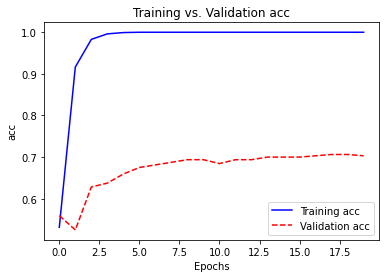

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_results(history, metric):
    plt.plot(history.history[metric], 'b', label='Training '+metric)
    plt.plot(history.history['val_'+metric], 'r--', label='Validation '+metric)
    plt.title('Training vs. Validation '+metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

plot_results(history, 'acc')

**성능 평가**

In [ ]:
# 테스트 셋으로 학습된 모형의 성능을 평가
score = model.evaluate(X_test, y_test)
print(f'#Test accuracy:{score[1]:.3f}')

13/13 [==============================] - 0s 3ms/step - loss: 0.5532 - acc: 0.6975
#Test accuracy:0.697
